In [174]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import random
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [178]:
image_size = 500  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
image_size_resized = 160
exampleImage = np.ndarray(shape=(image_size,image_size,3),dtype=np.float32)

class BatchGenerator(object):
    folder = ""
    globalIndex = 0
    def __init__(self, folder):
          self.folder = folder
    def getCategory(self,imageName):
        animal = imageName.split(".")[0]
        if animal == "cat":
            return 0
        else:
            return 1
    def processImageWithPadding(self,image_data):
        image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
        fullResult_resized = []
        if(image_data.shape[0]*image_data.shape[1]>image_size*image_size):
            fullResule_resized = imresize(image_data, (image_size_resized,image_size_resized), interp='bilinear', mode=None)
        else:
            fullResult = np.full(exampleImage.shape,0, dtype=exampleImage.dtype)
            #padding image with 0s
            fullResult[:image_data.shape[0],:image_data.shape[1],:image_data.shape[2]] = image_data
            fullResult_resized = imresize(fullResult, (image_size_resized,image_size_resized), interp='bilinear', mode=None)
            # show image if want
            #plt.imshow(fullResule_resized)
        return fullResult_resized
    
    def processImageWithResizing(self,image_data):
        fullResult_resized = imresize(image_data, (image_size_resized,image_size_resized), interp='bilinear', mode=None)
        return fullResult_resized
    
    def testBatch(self,folder):
        image_files = os.listdir(folder)
        datasetInput = np.zeros(shape=(len(image_files), image_size_resized, image_size_resized,3),
                                 dtype=np.float32)
        dataSetLabel = np.zeros(shape=(len(image_files)),
                                 dtype=np.float32)
        imageCount = 0
        for image in image_files[:30]:
            image_file = os.path.join(folder, image)
            try:
                image_data = (ndimage.imread(image_file).astype(float) - 
                                pixel_depth / 2) / pixel_depth
                fullResule_resized = self.processImageWithResizing(image_data)
                datasetInput[imageCount] = fullResule_resized
                # show image if want
                #plt.imshow(fullResule_resized)
            except IOError as e:
                  print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
            imageCount+=1
        datasetInput = datasetInput/pixel_depth
        return datasetInput  
    
    def nextBatch(self,shuffle=True,batchImageNumber=500):
          folder = self.folder
          print("loading data...")
          """Load the data for a single letter label."""
          image_files = os.listdir(folder)
          datasetInput = np.zeros(shape=(batchImageNumber, image_size_resized, image_size_resized,3),
                                 dtype=np.float32)
          dataSetLabel = np.zeros(shape=(batchImageNumber),
                                 dtype=np.float32)
          num_images = 0
          if shuffle == True:
            random.shuffle(image_files)
          
          trucks = len(image_files)//batchImageNumber
          index = self.globalIndex%trucks
          imageCount = 0
          for i in range(index*batchImageNumber,(index+1)*batchImageNumber):
            image = image_files[i]
            image_file = os.path.join(folder, image)
            try:
              image_data = (ndimage.imread(image_file).astype(float) - 
                            pixel_depth / 2) / pixel_depth
              fullResule_resized = self.processImageWithResizing(image_data)
              datasetInput[imageCount]=fullResule_resized
              dataSetLabel[imageCount]=self.getCategory(image)
            except IOError as e:
              print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
            imageCount += 1
          self.globalIndex += 1
          datasetInput = datasetInput/pixel_depth
          return datasetInput,dataSetLabel




loading data...
1.0
[ 0.8392157   0.74901962  0.78039217]


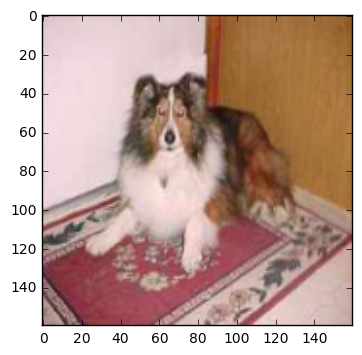

In [179]:
batchGenerator = BatchGenerator("cat_dog_train")
datasetInput,dataSetLabel = batchGenerator.nextBatch()
plt.imshow(datasetInput[0])
print(dataSetLabel[0])
print(datasetInput[0][0][0])

In [181]:

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


depth = 32
num_hidden = 300
num_hidden2 = 400

num_channels = 3
patch_size = 3

## Callback for loss logging per epoch
class LossHistory(Callback):
    losses = []
    val_losses = []
    #def on_train_begin(self, logs={}):
        
    
    def on_epoch_end(self, batch, logs={}):
       
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto') 


model = Sequential()
model.add(Convolution2D(depth, patch_size, patch_size, border_mode='same',subsample=(1,1) ,input_shape=(image_size_resized, image_size_resized, num_channels)))
model.add(Activation('relu')) 
model.add(Convolution2D(depth, patch_size, patch_size, border_mode='same'))#16x14x14x16
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, patch_size, patch_size, border_mode='same'))#16x14x14x16
model.add(Activation('relu'))
model.add(Convolution2D(64, patch_size, patch_size, border_mode='same'))#16x14x14x16
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, patch_size, patch_size, border_mode='same'))#16x14x14x16
model.add(Activation('relu'))
model.add(Convolution2D(128, patch_size, patch_size, border_mode='same'))#16x14x14x16
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, patch_size, patch_size, border_mode='same'))#16x14x14x16
model.add(Activation('relu'))
model.add(Convolution2D(256, patch_size, patch_size, border_mode='same'))#16x14x14x16
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())#16x(7x7x16)
model.add(Dense(num_hidden))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_hidden))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
optimizer=RMSprop(lr=1e-4),metrics=["accuracy"])

history = LossHistory()
nb_epoch = 10
for i in range(nb_epoch):
    print(i," :batch")
    train_dataset, train_labels = batchGenerator.nextBatch(batchImageNumber=500)
    model.fit(train_dataset, train_labels, validation_split=0.10,shuffle=True,nb_epoch=1,verbose=1,callbacks=[history, early_stopping])




0  :batch
loading data...
Train on 450 samples, validate on 50 samples
Epoch 1/1
450/450 [==============================] - 2s - loss: 7.7586 - acc: 0.5133 - val_loss: 7.9712 - val_acc: 0.5000
1  :batch
loading data...
Train on 450 samples, validate on 50 samples
Epoch 1/1
450/450 [==============================] - 1s - loss: 7.4398 - acc: 0.5333 - val_loss: 7.3335 - val_acc: 0.5400
2  :batch
loading data...
Train on 450 samples, validate on 50 samples
Epoch 1/1
450/450 [==============================] - 1s - loss: 7.6523 - acc: 0.5200 - val_loss: 7.3335 - val_acc: 0.5400
3  :batch
loading data...
Train on 450 samples, validate on 50 samples
Epoch 1/1
450/450 [==============================] - 1s - loss: 8.1483 - acc: 0.4889 - val_loss: 7.0146 - val_acc: 0.5600
4  :batch
loading data...
Train on 450 samples, validate on 50 samples
Epoch 1/1
450/450 [==============================] - 1s - loss: 7.8295 - acc: 0.5089 - val_loss: 6.3770 - val_acc: 0.6000
5  :batch
loading data...
Train on 

In [184]:
loss = history.losses
val_loss = history.val_losses
print(loss)

[7.7586276589499583, 7.439779904683431, 7.6523452292548289, 8.1483305231730139, 7.8294827651977537, 7.333497386508518, 8.4671781836615665, 8.4317508278952698, 7.4397800026999583, 8.1483304935031473]


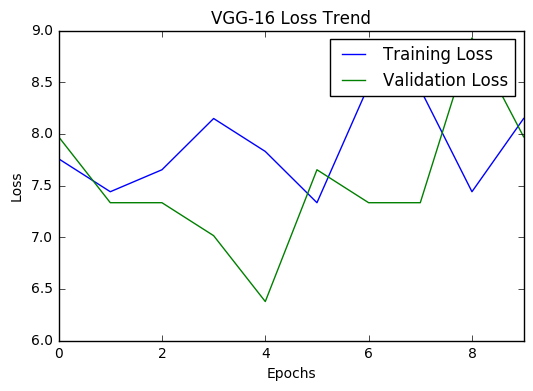

In [185]:

loss = history.losses
val_loss = history.val_losses



plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [186]:

testBatch = batchGenerator.testBatch(folder="cat_dog_test")
proba = model.predict(testBatch,verbose=0)




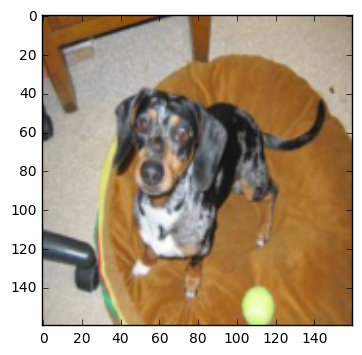

I am 100.00% sure this is a Dog


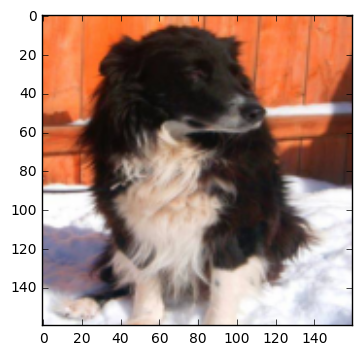

I am 100.00% sure this is a Dog


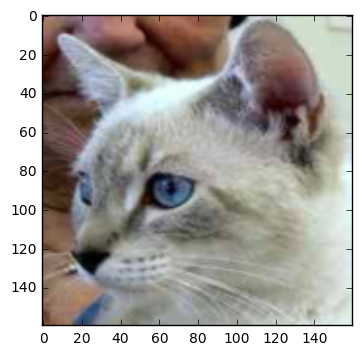

I am 100.00% sure this is a Dog


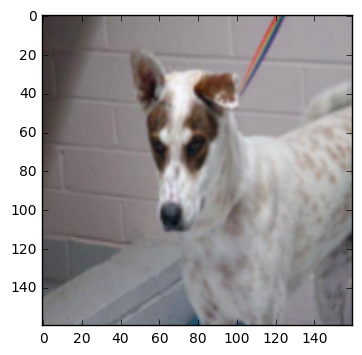

I am 100.00% sure this is a Dog


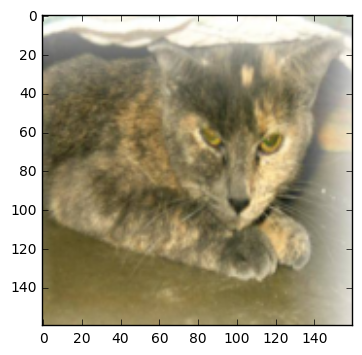

I am 100.00% sure this is a Dog


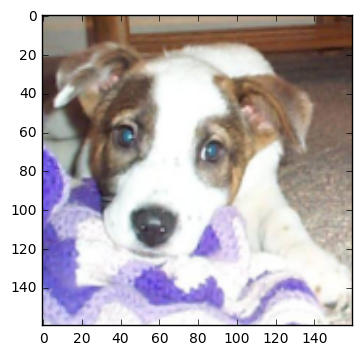

I am 100.00% sure this is a Dog


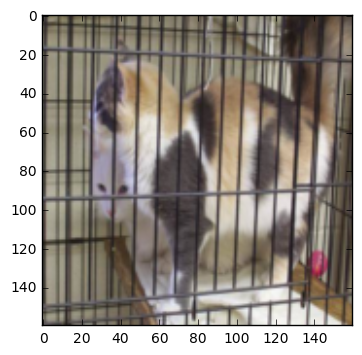

I am 100.00% sure this is a Dog


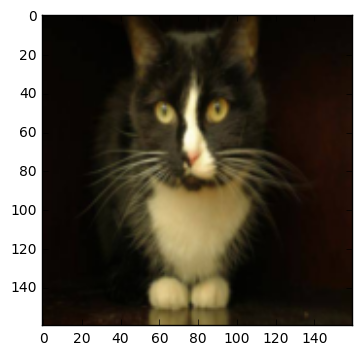

I am 100.00% sure this is a Dog


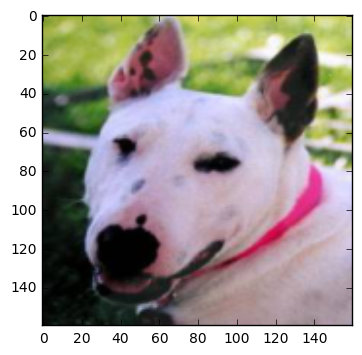

I am 100.00% sure this is a Dog


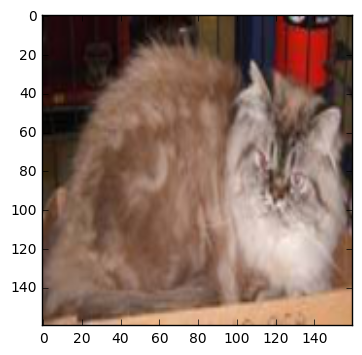

I am 100.00% sure this is a Dog


In [187]:
for i in range(0,10):
    plt.imshow(testBatch[i])
    plt.show()
    if proba[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(proba[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-proba[i][0]))

In [188]:
print(proba)

[[ 1.]
 [ 1.]
 [ 1.]
 ..., 
 [ 1.]
 [ 1.]
 [ 1.]]
